In [1]:

# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory

import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [2]:
# CIFAR 10 dataset

# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 49219286.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Choose random forget indecies from some class
# Index of class
class_index = 1 # cars
class_set = np.where(np.array(train_set.targets) == 1)[0]

# Percantage of whole data ( from class )
amount = 0.01 # 1 %
amount_int = class_set.shape[0] * amount

# Get indeces
forget_idx = np.random.choice(class_set, int(amount_int))

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

# Generate forget and retain loaders
forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
)

In [4]:

# Add helping dicts


dataloaders = {
    "train": train_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(train_set), "val": len(test_set)}

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [6]:

# Train ResNet18

model_train = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_train = model_train.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_train.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
# Train model
model_train = train_model(model_train, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.3764 Acc: 0.5047
val Loss: 1.1465 Acc: 0.5994

Epoch 1/14
----------
train Loss: 0.9597 Acc: 0.6594
val Loss: 1.0416 Acc: 0.6310

Epoch 2/14
----------
train Loss: 0.7674 Acc: 0.7301
val Loss: 1.0298 Acc: 0.6574

Epoch 3/14
----------
train Loss: 0.6471 Acc: 0.7721
val Loss: 0.9014 Acc: 0.7001

Epoch 4/14
----------
train Loss: 0.5345 Acc: 0.8139
val Loss: 0.9791 Acc: 0.6847

Epoch 5/14
----------
train Loss: 0.4418 Acc: 0.8452
val Loss: 0.8407 Acc: 0.7266

Epoch 6/14
----------
train Loss: 0.3573 Acc: 0.8747
val Loss: 0.8878 Acc: 0.7209

Epoch 7/14
----------
train Loss: 0.1505 Acc: 0.9553
val Loss: 0.7803 Acc: 0.7688

Epoch 8/14
----------
train Loss: 0.0763 Acc: 0.9808
val Loss: 0.8576 Acc: 0.7680

Epoch 9/14
----------
train Loss: 0.0448 Acc: 0.9904
val Loss: 0.9417 Acc: 0.7685

Epoch 10/14
----------
train Loss: 0.0250 Acc: 0.9955
val Loss: 1.0656 Acc: 0.7657

Epoch 11/14
----------
train Loss: 0.0133 Acc: 0.9979
val Loss: 1.1865 Acc: 0.7654

Ep

In [8]:
# Save model weights
torch.save(model_train.state_dict(), "model_train_params.pt")
# Save model weights
torch.save(model_train.state_dict(), "model_train_params_resnet18_cifar10.pt")

In [9]:

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model_train, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_train, test_loader):0.1f}%")

Train set accuracy: 98.3%
Test set accuracy: 76.9%


In [25]:
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts,StepLR
def kl_loss_sym(x,y):
    kl_loss = nn.KLDivLoss(reduction='batchmean')
    return kl_loss(nn.LogSoftmax(dim=-1)(x),y)

def unlearning(
        net,
        retain_loader,
        forget_loader,
        val_loader,
):
    """Simple unlearning by finetuning."""
    print('-----------------------------------')
    epochs = 8
    retain_bs = 256
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.005,
                          momentum=0.9, weight_decay=0)
    optimizer_retain = optim.SGD(net.parameters(), lr=0.001*retain_bs/64, momentum=0.9, weight_decay=1e-2)
    ##the learning rate is associated with the batchsize we used
    optimizer_forget = optim.SGD(net.parameters(), lr=3e-4, momentum=0.9, weight_decay=0)
    total_step = int(len(forget_loader)*epochs)
    retain_ld = DataLoader(retain_loader.dataset, batch_size=retain_bs, shuffle=True)
    retain_ld4fgt = DataLoader(retain_loader.dataset, batch_size=256, shuffle=True)
    scheduler = CosineAnnealingLR(optimizer_forget, T_max=total_step, eta_min=1e-6)

    net.train()
    for sample in forget_loader: ##First Stage
        inputs, output = sample
        inputs = inputs.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        uniform_label = torch.ones_like(outputs).to(DEVICE) / outputs.shape[1] ##uniform pseudo label
        loss = kl_loss_sym(outputs, uniform_label) ##optimize the distance between logits and pseudo labels
        loss.backward()
        optimizer.step()

    net.train()
    for ep in range(epochs): ##Second Stage
        net.train()
        for sample_forget, sample_retain in zip(forget_loader, retain_ld4fgt):##Forget Round
            t = 1.15 ##temperature coefficient
            inputs_forget,inputs_retain = sample_forget[0],sample_retain[0]
            inputs_forget, inputs_retain = inputs_forget.to(DEVICE), inputs_retain.to(DEVICE)
            optimizer_forget.zero_grad()
            outputs_forget,outputs_retain = net(inputs_forget),net(inputs_retain).detach()
            loss = (-1 * nn.LogSoftmax(dim=-1)(outputs_forget @ outputs_retain.T/t)).mean() ##Contrastive Learning loss
            loss.backward()
            optimizer_forget.step()
            scheduler.step()
        for sample in retain_ld: ##Retain Round
            inputs, labels = sample
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer_retain.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_retain.step()

    print('-----------------------------------')
    return net

In [26]:

# Define model from trained params

model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
model_forget_ft.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
# Unlearn model
%%time
model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

-----------------------------------
-----------------------------------
CPU times: user 2min 12s, sys: 998 ms, total: 2min 13s
Wall time: 2min 15s


In [28]:

# Compare accuracy
print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")


Retain set accuracy: 99.9%
Test set accuracy: 75.8%


In [29]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model_train, train_loader)
test_losses = compute_losses(model_train, test_loader)

In [30]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )


In [31]:
# TRAIN MODEL
# Get random test samples
randomize = np.arange(len(test_losses))
np.random.shuffle(randomize)

# Compute forget losses on train dataset
forget_losses = compute_losses(model_train, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
test_losses = test_losses[randomize][: len(forget_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)


The MIA has an accuracy of 0.710 on forgotten vs unseen images


In [32]:
# FORGET MODEL

# Compute forget losses for forget model
forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
test_losses_fr = compute_losses(model_ft_forget, test_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

# make sure we have a balanced dataset for the MIA
samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)

print(
    f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.810 on forgotten vs unseen images


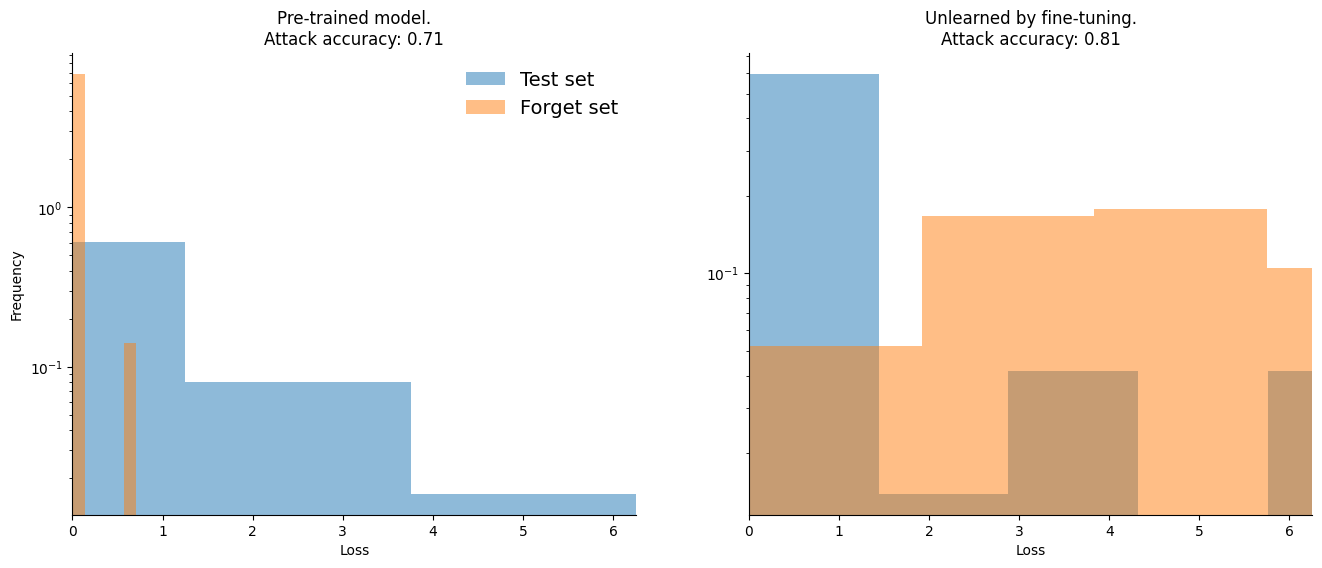

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=5, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=5, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {mia_scores_fr.mean():0.2f}"
)
ax2.hist(test_losses_fr, density=True, alpha=0.5, bins=5, label="Test set")
ax2.hist(forget_losses_fr, density=True, alpha=0.5, bins=5, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()



In [35]:
# Train ResNet18

model_retain_ds = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_retain_ds = model_retain_ds.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_retain_ds.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:

# Add helping dicts


dataloaders = {
    "train": retain_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(retain_set), "val": len(test_set)}

# Train model
model_retain_ds = train_model(model_retain_ds, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.3737 Acc: 0.5055
val Loss: 1.2962 Acc: 0.5442

Epoch 1/14
----------
train Loss: 0.9853 Acc: 0.6497
val Loss: 1.0237 Acc: 0.6413

Epoch 2/14
----------
train Loss: 0.8054 Acc: 0.7131
val Loss: 0.9900 Acc: 0.6651

Epoch 3/14
----------
train Loss: 0.6751 Acc: 0.7614
val Loss: 0.9043 Acc: 0.6939

Epoch 4/14
----------
train Loss: 0.5648 Acc: 0.8004
val Loss: 0.8196 Acc: 0.7239

Epoch 5/14
----------
train Loss: 0.4813 Acc: 0.8315
val Loss: 0.8998 Acc: 0.7169

Epoch 6/14
----------
train Loss: 0.3935 Acc: 0.8605
val Loss: 0.9093 Acc: 0.7240

Epoch 7/14
----------
train Loss: 0.1685 Acc: 0.9465
val Loss: 0.8005 Acc: 0.7674

Epoch 8/14
----------
train Loss: 0.0910 Acc: 0.9743
val Loss: 0.8670 Acc: 0.7680

Epoch 9/14
----------
train Loss: 0.0551 Acc: 0.9860
val Loss: 0.9562 Acc: 0.7660

Epoch 10/14
----------
train Loss: 0.0349 Acc: 0.9922
val Loss: 1.0740 Acc: 0.7634

Epoch 11/14
----------
train Loss: 0.0183 Acc: 0.9970
val Loss: 1.1763 Acc: 0.7633

Ep

In [37]:
# Save model weights
torch.save(model_retain_ds.state_dict(), "model_retrain_params_resnet18_cifar10.pt")

In [38]:

# MIA attack on retain model

# Compute forget losses for forget model
forget_losses_rt = compute_losses(model_retain_ds, forget_loader)
test_losses_rt = compute_losses(model_retain_ds, test_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
test_losses_rt = test_losses_rt[randomize][: len(forget_losses)]

# make sure we have a balanced dataset for the MIA
samples_mia_rt = np.concatenate((test_losses_rt, forget_losses_rt)).reshape((-1, 1))
labels_mia_rt = [0] * len(test_losses_rt) + [1] * len(forget_losses_rt)

mia_scores_rt = simple_mia(samples_mia_rt, labels_mia_rt)

print(
    f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.810 on forgotten vs unseen images


In [39]:

AD = np.linalg.norm(forget_losses_fr-forget_losses_rt)

In [40]:
AD

33.1726

In [41]:
# Generalisation
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.01 # 1 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 75.8%
The MIA has an accuracy of 0.870 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.630 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.830 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 76.2%
The MIA has an accuracy of 0.840 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 76.3%
The MIA has an accuracy of 0.840 on forgotten vs unseen images
-----------------------------------
-----------------------------

In [42]:

MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)


[0.8700000000000001, 0.6299999999999999, 0.8300000000000001, 0.8399999999999999, 0.8400000000000001, 0.75, 0.89, 0.8200000000000001, 0.7700000000000001, 0.78]
[99.83583912233989, 99.88188188188188, 99.84584584584584, 99.7917917917918, 99.81581950311305, 99.87187187187187, 99.86786786786787, 99.85986266541211, 99.84985285579869, 99.77377377377378]
[75.88000000000001, 75.94, 76.35, 76.08, 76.35, 75.67, 75.66000000000001, 75.99000000000001, 75.56, 75.81]


In [43]:
# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)

In [44]:

print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)


0.8019999999999999
99.83944071796968
75.929


In [45]:
# Generalisation 2 %
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.02 # 2 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.913 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 75.8%
The MIA has an accuracy of 0.847 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 75.4%
The MIA has an accuracy of 0.900 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.847 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 76.0%
The MIA has an accuracy of 0.867 on forgotten vs unseen images
-----------------------------------
-----------------------------

In [46]:

MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)

[0.9133333333333334, 0.8466666666666667, 0.9, 0.8466666666666667, 0.8666666666666668, 0.8533333333333333, 0.86, 0.8733333333333333, 0.9133333333333334, 0.8866666666666667]
[99.88777555110221, 99.87174862730953, 99.75952385723733, 99.88577383218772, 99.77555560008817, 99.87174862730953, 99.7154365643975, 99.86973947895792, 99.86773547094188, 99.87975951903807]
[75.97, 75.91, 75.77000000000001, 75.78, 75.92999999999999, 75.69, 75.37, 75.82, 75.55, 76.09]


In [47]:

# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)


In [48]:
print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)

0.8760000000000001
99.83847971285698
75.788


In [49]:
# Generalisation 2 %
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.05 # 2 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.880 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 76.2%
The MIA has an accuracy of 0.887 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 76.4%
The MIA has an accuracy of 0.890 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 76.0%
The MIA has an accuracy of 0.873 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.6%
Test set accuracy: 75.7%
The MIA has an accuracy of 0.927 on forgotten vs unseen images
-----------------------------------
-----------------------------

In [50]:
MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)


[0.8800000000000001, 0.8866666666666665, 0.89, 0.8733333333333334, 0.9266666666666667, 0.9099999999999999, 0.8633333333333333, 0.8733333333333334, 0.8733333333333334, 0.9133333333333334]
[99.8713671262612, 99.85730077379158, 99.83518581794063, 99.90352340562379, 99.6121304688599, 99.88945390227725, 99.89748949769854, 99.87338464939607, 99.86132325749658, 99.79097578132851]
[75.98, 76.28, 76.36, 76.07000000000001, 75.64999999999999, 75.42999999999999, 75.78, 75.74, 75.92, 75.77000000000001]


In [51]:

# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)


In [52]:
print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)


0.889
99.8392134680674
75.898


In [53]:
# Generalisation 2 %
# Calculating score across 10 different classes

# Show different classes
classes = np.unique(np.array(train_set.targets))

MIA_scores = []
Accuracy_retain = []
Accuracy_forget = []
AD_score = []

for class_num in classes:
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load("model_train_params.pt"))
  model_forget_ft.to(DEVICE)

  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == 1)[0]

  # Percantage of whole data ( from class )
  amount = 0.1 # 2 %
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, test_loader))

  # MIA

  # Compute forget losses for forget model
  forget_losses_fr = compute_losses(model_ft_forget, forget_loader)
  test_losses_fr = compute_losses(model_ft_forget, test_loader)

  # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
  test_losses_fr = test_losses_fr[randomize][: len(forget_losses)]

  # make sure we have a balanced dataset for the MIA
  samples_mia_fr = np.concatenate((test_losses_fr, forget_losses_fr)).reshape((-1, 1))
  labels_mia_fr = [0] * len(test_losses_fr) + [1] * len(forget_losses_fr)

  mia_scores_fr = simple_mia(samples_mia_fr, labels_mia_fr)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr.mean():.3f} on forgotten vs unseen images"
  )

-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 75.8%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 76.1%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.9%
Test set accuracy: 76.0%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
-----------------------------------
-----------------------------------
Retain set accuracy: 99.8%
Test set accuracy: 75.9%
The MIA has an accuracy of 0.909 on forgotten vs unseen images
-----------------------------------
-----------------------------

In [54]:

MIA_scores = [m.mean() for m in MIA_scores]
print(MIA_scores)
print(Accuracy_retain)
print(Accuracy_forget)

[0.909090909090909, 0.909090909090909, 0.909090909090909, 0.909090909090909, 0.909090909090909, 0.909090909090909, 0.909090909090909, 0.909090909090909, 0.909090909090909, 0.909090909090909]
[99.77186465315351, 99.89094213874583, 99.91721687160539, 99.85262052814342, 99.80412745850329, 99.85864011793453, 99.84252286446872, 99.86268729049715, 99.83442371375494, 99.89095315024232]
[75.9, 76.22, 75.96000000000001, 75.83, 76.1, 75.97, 75.96000000000001, 75.62, 75.59, 75.99000000000001]


In [55]:

# Mean MIA
mean_mia_1 = sum(MIA_scores) / len(MIA_scores)

# Mean Accuracy Retain
mean_accuracy_retain = sum(Accuracy_retain) / len(Accuracy_retain)

# Mean Accuracy forget
mean_accuracy_forget = sum(Accuracy_forget) / len(Accuracy_forget)

In [56]:

print(mean_mia_1)
print(mean_accuracy_retain)
print(mean_accuracy_forget)

0.909090909090909
99.85259987870491
75.91400000000002
